# Supervised Learning Burn Severity

In [147]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
#load in modules
%autoreload 2
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
import geopandas as gpd
import numpy as np
import numpy.ma as ma
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

## Load segments
Read vector files into geodataframes. Then will convert to Numpy matrix X and y

In [3]:
#read in datapaths of labelled data
filepaths = [Path("./data/shapefiles/segments_2011023_0.shp"), Path("./data/shapefiles/segments_2011201_0.shp"),
             Path("./data/shapefiles/segments_2011203_0.shp"), Path("./data/shapefiles/segments_2010133_0.shp"),
             Path("./data/shapefiles/segments_2011200_0.shp")]

In [4]:
gdfs = []
for filepath in filepaths:
    gdfs.append(gpd.read_file(filepath))
gdfs[0].head()

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...


In [5]:
#'Blue_value' - 'dSI_bn' will be X, y is 'burn_class' 
gdfs[0].keys()

Index(['seg_index', 'area_m', 'blue_value', 'blue_val_1', 'green_valu',
       'green_va_1', 'nir_value', 'nir_value_', 'red_value', 'red_value_',
       'SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_gb_post', 'SI_gr_post',
       'SI_gn_post', 'SI_rb_post', 'SI_rg_post', 'SI_rn_post', 'SI_nb_post',
       'SI_ng_post', 'SI_nr_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
       'SI_gb_pre', 'SI_gr_pre', 'SI_gn_pre', 'SI_rb_pre', 'SI_rg_pre',
       'SI_rn_pre', 'SI_nb_pre', 'SI_ng_pre', 'SI_nr_pre', 'dSI_nb', 'dSI_rg',
       'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_rb', 'dSI_br', 'dSI_gb', 'dSI_nr',
       'dSI_rn', 'dSI_ng', 'dSI_bn', 'land_class', 'burn_class', 'geometry'],
      dtype='object')

### Read as Numpy array and clean data of missing values

In [6]:
#build X and y
X = gdfs[0].loc[:, 'blue_value':'dSI_bn'].to_numpy()
y = gdfs[0]['burn_class'].to_numpy().astype(int)

for i in range(1, len(gdfs)):
    X_1 = gdfs[i].loc[:,'blue_value':'dSI_bn'].to_numpy()
    X = np.vstack((X, X_1))
    
    y_1 = gdfs[i]['burn_class'].to_numpy().astype(int)
    y = np.hstack((y, y_1))
    


In [7]:
#rows where the labels are. will remove these rows with minimum int label.
locsMins = np.where(y != np.iinfo(np.int32).min)[0]
locsMins.shape

(14086,)

In [8]:
#remove the non-labels
X = X[locsMins]
y = y[locsMins]

print("rows/col of X: ", X.shape)
print("# target values: ", y.shape)
print("labels for burn_class: ", np.unique(y))

rows/col of X:  (14086, 44)
# target values:  (14086,)
labels for burn_class:  [0 1]


In [9]:
class_names = np.where(np.unique(y) == 1, "burnt", "non-burnt")
class_names

array(['non-burnt', 'burnt'], dtype='<U9')

### X y shuffled train-test split 67/33

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [11]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

print("\n# of burn labels in train: ", np.count_nonzero(y_train))
print("# of non-burn labels in train: ", y_train.shape[0]-np.count_nonzero(y_train))
print("# of burn labels in test: ", np.count_nonzero(y_test))
print("# of non-burn labels in test: ", y_test.shape[0]-np.count_nonzero(y_test))

train shape:  (9437, 44)
test shape:  (4649, 44)

# of burn labels in train:  6056
# of non-burn labels in train:  3381
# of burn labels in test:  2983
# of non-burn labels in test:  1666


# Binary Classification Burnt/Non-Burnt

## Random Forest Classifier

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf.score(X_test, y_test)

0.8584641858464186

Confusion matrix, without normalization
[[1312  354]
 [ 304 2679]]
Normalized confusion matrix
[[0.78751501 0.21248499]
 [0.10191083 0.89808917]]


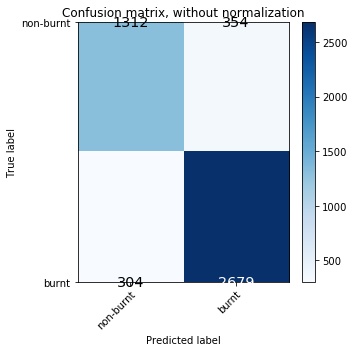

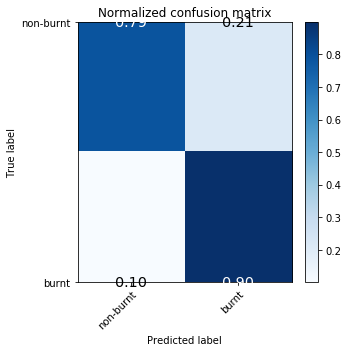

In [67]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [68]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1312, 354, 304, 2679)
	Accuracy = 85.85%
	Misclassification Rate = 14.15%
	Precision = 88.33%
	Recall = 89.81%
	F1-Score = 89.06%


#### Cross_val_score

In [107]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=10)
scores_rf_p = cross_val_score(rf, X_train, y_train, scoring='precision', cv=10)
scores_rf_r = cross_val_score(rf, X_train, y_train, scoring='recall', cv=10)
scores_rf_f = cross_val_score(rf, X_train, y_train, scoring='f1', cv=10)
scores_rf

array([0.85714286, 0.86440678, 0.85169492, 0.85699153, 0.87182203,
       0.84957627, 0.86744433, 0.85471898, 0.8621421 , 0.85896076])

In [119]:
def strScoreConf(mean, std, conf=1.96):
    return "%0.4f (+/- %0.4f)" % (mean, std * 1.96)

models_df_rf = pd.DataFrame({  
  'Model': ['RandForest'],
  'Accuracy' : [strScoreConf(scores_rf.mean(), scores_rf.std())],
  'Precision': [strScoreConf(scores_rf_p.mean(), scores_rf_p.std())],
  'recall' : [strScoreConf(scores_rf_r.mean(), scores_rf_r.std())],
  'F1' : [strScoreConf(scores_rf_f.mean(), scores_rf_f.std())]
})
models_df_rf

,Model,Accuracy,Precision,recall,F1
0,RandForest,0.8595 (+/- 0.0130),0.8821 (+/- 0.0264),0.8885 (+/- 0.0168),0.8919 (+/- 0.0114)


## Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr.score(X_test, y_test)

0.8337276833727684

Confusion matrix, without normalization
[[1112  554]
 [ 219 2764]]
Normalized confusion matrix
[[0.66746699 0.33253301]
 [0.07341602 0.92658398]]


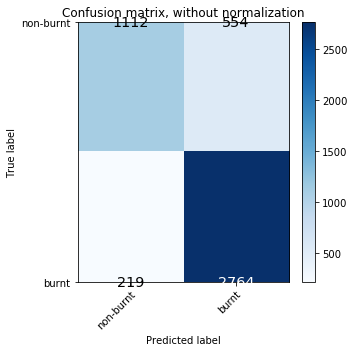

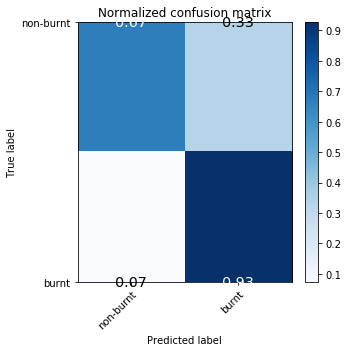

In [16]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [17]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1112, 554, 219, 2764)
	Accuracy = 83.37%
	Misclassification Rate = 16.63%
	Precision = 83.30%
	Recall = 92.66%
	F1-Score = 87.73%


#### Cross Validation

In [109]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=10)
scores_lr_p = cross_val_score(lr, X_train, y_train, scoring='precision', cv=10)
scores_lr_r = cross_val_score(lr, X_train, y_train, scoring='recall', cv=10)
scores_lr_f = cross_val_score(lr, X_train, y_train, scoring='f1', cv=10)
scores_lr

array([0.83068783, 0.82733051, 0.81885593, 0.82309322, 0.8559322 ,
       0.83686441, 0.85896076, 0.82078473, 0.82926829, 0.83669141])

In [120]:
models_df_lr = pd.DataFrame({
  'Model': ['LogReg'],
  'Accuracy' : [strScoreConf(scores_lr.mean(), scores_lr.std())],
  'Precision': [strScoreConf(scores_lr_p.mean(), scores_lr_p.std())],
  'recall' : [strScoreConf(scores_lr_r.mean(), scores_lr_r.std())],
  'F1' : [strScoreConf(scores_lr_f.mean(), scores_lr_f.std())]
})
models_df_lr

,Model,Accuracy,Precision,recall,F1
0,LogReg,0.8338 (+/- 0.0257),0.8384 (+/- 0.0267),0.9184 (+/- 0.0216),0.8765 (+/- 0.0183)


## Naive Bayes

### Gaussian NB

In [18]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict = gnb.predict(X_test)
gnb.score(X_test, y_test)

0.8115723811572381

Confusion matrix, without normalization
[[1118  548]
 [ 328 2655]]
Normalized confusion matrix
[[0.67106843 0.32893157]
 [0.10995642 0.89004358]]


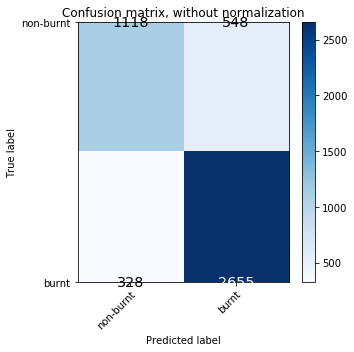

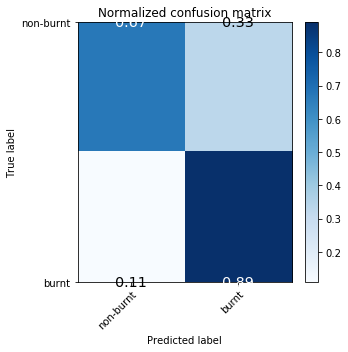

In [19]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [20]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1118, 548, 328, 2655)
	Accuracy = 81.16%
	Misclassification Rate = 18.84%
	Precision = 82.89%
	Recall = 89.00%
	F1-Score = 85.84%


#### Cross-validation

In [121]:
scores_gnb = cross_val_score(gnb, X_train, y_train, cv=10)
scores_gnb_p = cross_val_score(gnb, X_train, y_train, scoring='precision', cv=10)
scores_gnb_r = cross_val_score(gnb, X_train, y_train, scoring='recall', cv=10)
scores_gnb_f = cross_val_score(gnb, X_train, y_train, scoring='f1', cv=10)
scores_gnb

array([0.82116402, 0.81567797, 0.8029661 , 0.81567797, 0.82309322,
       0.81673729, 0.83032874, 0.81018028, 0.82502651, 0.80275716])

In [122]:
models_df_gnb = pd.DataFrame({  
  'Model': ['GaussNB'],
  'Accuracy' : [strScoreConf(scores_gnb.mean(), scores_gnb.std())],
  'Precision': [strScoreConf(scores_gnb_p.mean(), scores_gnb_p.std())],
  'recall' : [strScoreConf(scores_gnb_r.mean(), scores_gnb_r.std())],
  'F1' : [strScoreConf(scores_gnb_f.mean(), scores_gnb_f.std())]
})
models_df_gnb

,Model,Accuracy,Precision,recall,F1
0,GaussNB,0.8164 (+/- 0.0169),0.8396 (+/- 0.0201),0.8826 (+/- 0.0167),0.8605 (+/- 0.0120)


### Bernoulli NB

In [21]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_predict = bnb.predict(X_test)
bnb.score(X_test, y_test)

0.7515594751559476

Confusion matrix, without normalization
[[ 729  937]
 [ 218 2765]]
Normalized confusion matrix
[[0.43757503 0.56242497]
 [0.07308079 0.92691921]]


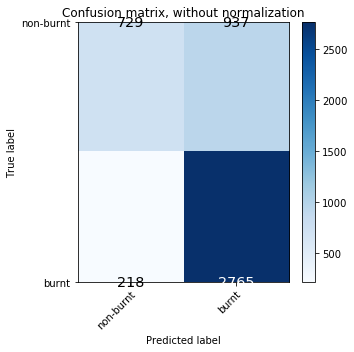

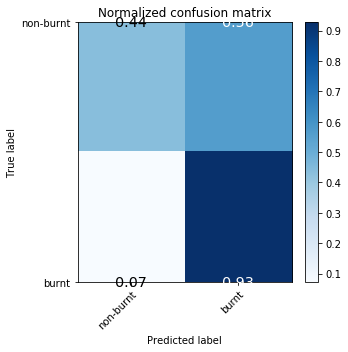

In [22]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (729, 937, 218, 2765)
	Accuracy = 75.16%
	Misclassification Rate = 24.84%
	Precision = 74.69%
	Recall = 92.69%
	F1-Score = 82.72%


#### Cross-validation

In [128]:
scores_bnb = cross_val_score(bnb, X_train, y_train, cv=10)
scores_bnb_p = cross_val_score(bnb, X_train, y_train, scoring='precision', cv=10)
scores_bnb_r = cross_val_score(bnb, X_train, y_train, scoring='recall', cv=10)
scores_bnb_f = cross_val_score(bnb, X_train, y_train, scoring='f1', cv=10)
scores_bnb

array([0.76402116, 0.76588983, 0.74470339, 0.74576271, 0.7690678 ,
       0.76800847, 0.76458112, 0.76352068, 0.75503712, 0.76352068])

In [129]:
models_df_bnb = pd.DataFrame({  
  'Model': ['BernNB'],
  'Accuracy' : [strScoreConf(scores_bnb.mean(), scores_bnb.std())],
  'Precision': [strScoreConf(scores_bnb_p.mean(), scores_bnb_p.std())],
  'recall' : [strScoreConf(scores_bnb_r.mean(), scores_bnb_r.std())],
  'F1' : [strScoreConf(scores_bnb_f.mean(), scores_bnb_f.std())]
})
models_df_bnb

,Model,Accuracy,Precision,recall,F1
0,BernNB,0.7604 (+/- 0.0164),0.7559 (+/- 0.0168),0.9259 (+/- 0.0152),0.8322 (+/- 0.0098)


## Stochastic Gradient Descent (SGD)

In [125]:
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, y_train)
y_predict = sgd.predict(X_test)
sgd.score(X_test, y_test) #around 72-78%

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.7618842761884276

Confusion matrix, without normalization
[[ 653 1013]
 [  94 2889]]
Normalized confusion matrix
[[0.39195678 0.60804322]
 [0.0315119  0.9684881 ]]


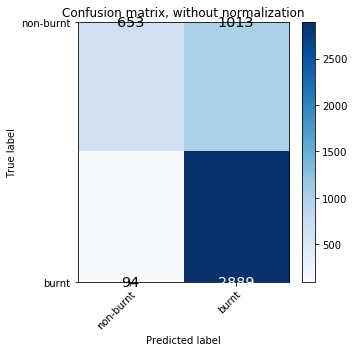

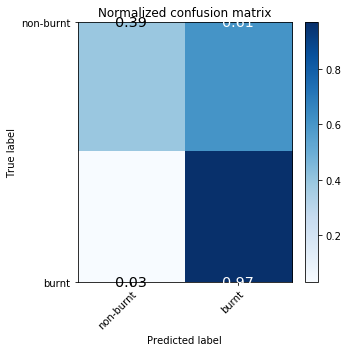

In [126]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [127]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (653, 1013, 94, 2889)
	Accuracy = 76.19%
	Misclassification Rate = 23.81%
	Precision = 74.04%
	Recall = 96.85%
	F1-Score = 83.92%


#### Cross-validation

In [130]:
scores_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
scores_sgd_p = cross_val_score(sgd, X_train, y_train, scoring='precision', cv=10)
scores_sgd_r = cross_val_score(sgd, X_train, y_train, scoring='recall', cv=10)
scores_sgd_f = cross_val_score(sgd, X_train, y_train, scoring='f1', cv=10)
scores_sgd

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

array([0.75661376, 0.75317797, 0.77012712, 0.71398305, 0.74152542,
       0.72987288, 0.78685048, 0.7804878 , 0.79851538, 0.7009544 ])

In [132]:
models_df_sgd = pd.DataFrame({  
  'Model': ['SGD'],
  'Accuracy' : [strScoreConf(scores_sgd.mean(), scores_sgd.std())],
  'Precision': [strScoreConf(scores_sgd_p.mean(), scores_sgd_p.std())],
  'recall' : [strScoreConf(scores_sgd_r.mean(), scores_sgd_r.std())],
  'F1' : [strScoreConf(scores_sgd_f.mean(), scores_sgd_f.std())]
})
models_df_sgd

,Model,Accuracy,Precision,recall,F1
0,SGD,0.7532 (+/- 0.0594),0.8246 (+/- 0.2086),0.7619 (+/- 0.5729),0.7284 (+/- 0.3652)


## K-Nearest Neighbors

In [27]:
knn = KNeighborsClassifier() # n = 5
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.8352333835233383

Confusion matrix, without normalization
[[1193  473]
 [ 293 2690]]
Normalized confusion matrix
[[0.71608643 0.28391357]
 [0.09822327 0.90177673]]


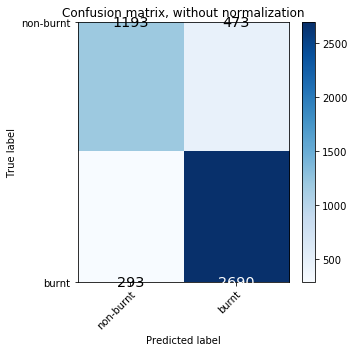

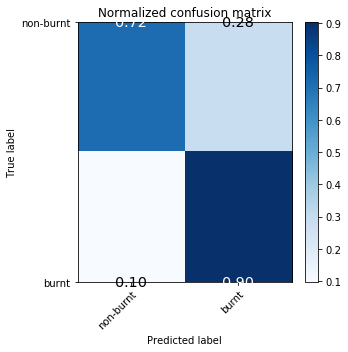

In [28]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1193, 473, 293, 2690)
	Accuracy = 83.52%
	Misclassification Rate = 16.48%
	Precision = 85.05%
	Recall = 90.18%
	F1-Score = 87.54%


#### Cross-validation

In [133]:
scores_knn = cross_val_score(knn, X_train, y_train, cv=10)
scores_knn_p = cross_val_score(knn, X_train, y_train, scoring='precision', cv=10)
scores_knn_r = cross_val_score(knn, X_train, y_train, scoring='recall', cv=10)
scores_knn_f = cross_val_score(knn, X_train, y_train, scoring='f1', cv=10)
scores_knn

array([0.83492063, 0.82627119, 0.81567797, 0.83368644, 0.84322034,
       0.83580508, 0.83244963, 0.82820785, 0.84305408, 0.83669141])

In [134]:
models_df_knn = pd.DataFrame({  
  'Model': ['KNN'],
  'Accuracy' : [strScoreConf(scores_knn.mean(), scores_knn.std())],
  'Precision': [strScoreConf(scores_knn_p.mean(), scores_knn_p.std())],
  'recall' : [strScoreConf(scores_knn_r.mean(), scores_knn_r.std())],
  'F1' : [strScoreConf(scores_knn_f.mean(), scores_knn_f.std())]
})
models_df_knn

,Model,Accuracy,Precision,recall,F1
0,KNN,0.8330 (+/- 0.0152),0.8514 (+/- 0.0143),0.8963 (+/- 0.0317),0.8732 (+/- 0.0132)


## Decision Tree

In [30]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_predict = dtc.predict(X_test)
dtc.score(X_test, y_test)

0.804258980425898

Confusion matrix, without normalization
[[1196  470]
 [ 440 2543]]
Normalized confusion matrix
[[0.71788715 0.28211285]
 [0.14750251 0.85249749]]


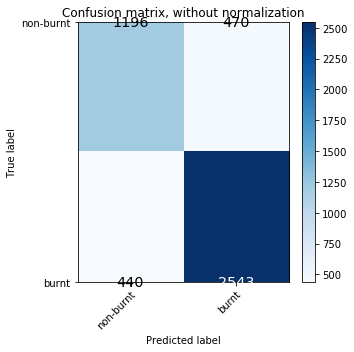

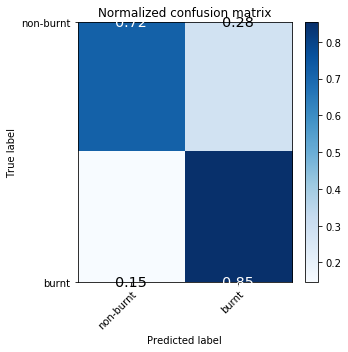

In [31]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [32]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1196, 470, 440, 2543)
	Accuracy = 80.43%
	Misclassification Rate = 19.57%
	Precision = 84.40%
	Recall = 85.25%
	F1-Score = 84.82%


#### Cross-validation

In [135]:
scores_dtc = cross_val_score(dtc, X_train, y_train, cv=10)
scores_dtc_p = cross_val_score(dtc, X_train, y_train, scoring='precision', cv=10)
scores_dtc_r = cross_val_score(dtc, X_train, y_train, scoring='recall', cv=10)
scores_dtc_f = cross_val_score(dtc, X_train, y_train, scoring='f1', cv=10)
scores_dtc

array([0.78518519, 0.79555085, 0.78919492, 0.8029661 , 0.81885593,
       0.79872881, 0.80699894, 0.80487805, 0.79321315, 0.7921527 ])

In [136]:
models_df_dtc = pd.DataFrame({  
  'Model': ['DecnTree'],
  'Accuracy' : [strScoreConf(scores_dtc.mean(), scores_dtc.std())],
  'Precision': [strScoreConf(scores_dtc_p.mean(), scores_dtc_p.std())],
  'recall' : [strScoreConf(scores_dtc_r.mean(), scores_dtc_r.std())],
  'F1' : [strScoreConf(scores_dtc_f.mean(), scores_dtc_f.std())]
})
models_df_dtc

,Model,Accuracy,Precision,recall,F1
0,DecnTree,0.7988 (+/- 0.0185),0.8439 (+/- 0.0093),0.8451 (+/- 0.0227),0.8436 (+/- 0.0125)


## SVM

In [33]:
#Support Vector Classifier
svc_lin = svm.SVC(kernel='linear')
svc_rbf = svm.SVC(kernel='rbf')
svc_poly = svm.SVC(kernel='poly')

svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
svc_poly.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
y_pred_l = svc_lin.predict(X_test)
y_pred_r = svc_rbf.predict(X_test)
y_pred_p = svc_poly.predict(X_test)

#### Results SVC linear kernel

In [36]:
print(confusion_matrix(y_test, y_pred_l))
print_scores(y_test, y_pred_l)

[[1081  585]
 [ 199 2784]]
	(tn, fp, fn, tp) = (1081, 585, 199, 2784)
	Accuracy = 83.14%
	Misclassification Rate = 16.86%
	Precision = 82.64%
	Recall = 93.33%
	F1-Score = 87.66%


#### Results SVC RBF kernel

In [38]:
print(confusion_matrix(y_test, y_pred_r))
print_scores(y_test, y_pred_r)

[[ 878  788]
 [ 173 2810]]
	(tn, fp, fn, tp) = (878, 788, 173, 2810)
	Accuracy = 79.33%
	Misclassification Rate = 20.67%
	Precision = 78.10%
	Recall = 94.20%
	F1-Score = 85.40%


#### Results SVC polynomial kernel

In [40]:
print(confusion_matrix(y_test, y_pred_p))
print_scores(y_test, y_pred_p)

[[1198  468]
 [ 238 2745]]
	(tn, fp, fn, tp) = (1198, 468, 238, 2745)
	Accuracy = 84.81%
	Misclassification Rate = 15.19%
	Precision = 85.43%
	Recall = 92.02%
	F1-Score = 88.61%


#### Cross-validation

In [153]:
#trying RBF since it is the default parameter
scores_svc = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, cv=10)
scores_svc_p = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='precision', cv=10)
scores_svc_r = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='recall', cv=10)
scores_svc_f = cross_val_score(svm.SVC(max_iter=10000), X_train, y_train, scoring='f1', cv=10)
scores_svc

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  %

array([0.78201058, 0.78495763, 0.77860169, 0.79661017, 0.78283898,
       0.77648305, 0.78366914, 0.77518558, 0.7826087 , 0.77518558])

In [154]:
models_df_svc = pd.DataFrame({  
  'Model': ['SVM'],
  'Accuracy' : [strScoreConf(scores_svc.mean(), scores_svc.std())],
  'Precision': [strScoreConf(scores_svc_p.mean(), scores_svc_p.std())],
  'recall' : [strScoreConf(scores_svc_r.mean(), scores_svc_r.std())],
  'F1' : [strScoreConf(scores_svc_f.mean(), scores_svc_f.std())]
})
models_df_svc

,Model,Accuracy,Precision,recall,F1
0,SVM,0.7818 (+/- 0.0118),0.7701 (+/- 0.0093),0.9409 (+/- 0.0156),0.8470 (+/- 0.0085)


## ANN - Multi-layer Perceptron Classifier (MLP)

In [58]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_predict = mlp.predict(X_test)
knn.score(X_test, y_test)

0.8352333835233383

Confusion matrix, without normalization
[[1214  452]
 [ 282 2701]]
Normalized confusion matrix
[[0.72869148 0.27130852]
 [0.0945357  0.9054643 ]]


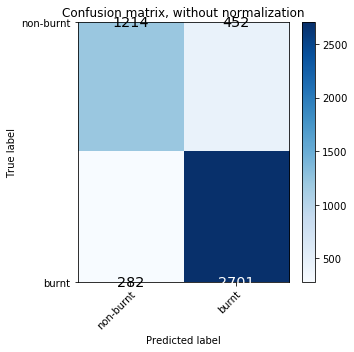

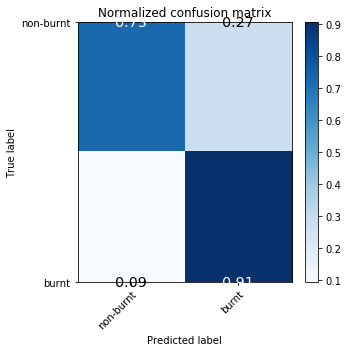

In [59]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [60]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1214, 452, 282, 2701)
	Accuracy = 84.21%
	Misclassification Rate = 15.79%
	Precision = 85.66%
	Recall = 90.55%
	F1-Score = 88.04%


#### Cross-validation

In [137]:
scores_mlp = cross_val_score(mlp, X_train, y_train, cv=10)
scores_mlp_p = cross_val_score(mlp, X_train, y_train, scoring='precision', cv=10)
scores_mlp_r = cross_val_score(mlp, X_train, y_train, scoring='recall', cv=10)
scores_mlp_f = cross_val_score(mlp, X_train, y_train, scoring='f1', cv=10)
scores_mlp

array([0.83068783, 0.84533898, 0.81673729, 0.82309322, 0.85381356,
       0.82944915, 0.85683987, 0.81760339, 0.83669141, 0.82608696])

In [140]:
models_df_mlp = pd.DataFrame({  
  'Model': ['ANN-MLP'],
  'Accuracy' : [strScoreConf(scores_mlp.mean(), scores_mlp.std())],
  'Precision': [strScoreConf(scores_mlp_p.mean(), scores_mlp_p.std())],
  'recall' : [strScoreConf(scores_mlp_r.mean(), scores_mlp_r.std())],
  'F1' : [strScoreConf(scores_mlp_f.mean(), scores_mlp_f.std())]
})
models_df_mlp

,Model,Accuracy,Precision,recall,F1
0,ANN-MLP,0.8336 (+/- 0.0265),0.8618 (+/- 0.0630),0.8925 (+/- 0.1178),0.8624 (+/- 0.0397)


#### Save models via Pickle

In [46]:
import pickle
filepath = Path("./models")

In [47]:
#random forest
filenameRF = filepath / "randomForest_default.sav"
pickle.dump(rf, open(filenameRF, 'wb'))

In [50]:
#logistic regression
filenameLR = filepath / "logisticRegression_default.sav"
pickle.dump(lr, open(filenameLR, 'wb'))

In [51]:
#Gaussian Naive Bayes
filenameGNB = filepath / "gaussNB_default.sav"
pickle.dump(gnb, open(filenameGNB, 'wb'))

#Bernoulli Naive Bayes
filenameBNB = filepath / "bernNB_default.sav"
pickle.dump(bnb, open(filenameBNB, 'wb'))

In [52]:
#Stochastic Gradient Descent
filenameSGD = filepath / "stochGradDesc_default.sav"
pickle.dump(sgd, open(filenameSGD, 'wb'))

In [53]:
#K-Nearest Neighbors - k=5
filenameKNN = filepath / "kNearestNeigh_default.sav"
pickle.dump(knn, open(filenameKNN, 'wb'))

In [54]:
#Decision Tree Classifier
filenameDTC = filepath / "decisionTree_default.sav"
pickle.dump(dtc, open(filenameDTC, 'wb'))

In [55]:
#Support Vector Machine - Linear Kernel
filenameSVCLin = filepath / "svm_lin_default.sav"
pickle.dump(svc_lin, open(filenameSVCLin, 'wb'))

#Support Vector Machine - Radial Basis Function (RBF) Kernel
filenameSVCRbf = filepath / "svm_rbf_default.sav"
pickle.dump(svc_rbf, open(filenameSVCRbf, 'wb'))

#Support Vector Machine - Polynomial Kernel
filenameSVCPoly = filepath / "svm_poly_default.sav"
pickle.dump(svc_poly, open(filenameSVCPoly, 'wb'))

In [61]:
#Multi-Layer Perceptron Network (MLP)
filenameMLP = filepath / "mlp_default.sav"
pickle.dump(mlp, open(filenameMLP, 'wb'))

In [65]:
#save X and y numpy arrays
filepathData = Path("./data")
np.save(filepathData / "X.npy", X)
np.save(filepathData / "y.npy", y)

## Cross-validation metrics

In [155]:
models_df = pd.concat([models_df_rf, models_df_lr, models_df_gnb, models_df_bnb,
                       models_df_sgd, models_df_knn, models_df_dtc, models_df_svc, models_df_mlp])
models_df.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,recall,F1
0,RandForest,0.8595 (+/- 0.0130),0.8821 (+/- 0.0264),0.8885 (+/- 0.0168),0.8919 (+/- 0.0114)
0,ANN-MLP,0.8336 (+/- 0.0265),0.8618 (+/- 0.0630),0.8925 (+/- 0.1178),0.8624 (+/- 0.0397)
0,KNN,0.8330 (+/- 0.0152),0.8514 (+/- 0.0143),0.8963 (+/- 0.0317),0.8732 (+/- 0.0132)
0,DecnTree,0.7988 (+/- 0.0185),0.8439 (+/- 0.0093),0.8451 (+/- 0.0227),0.8436 (+/- 0.0125)
0,GaussNB,0.8164 (+/- 0.0169),0.8396 (+/- 0.0201),0.8826 (+/- 0.0167),0.8605 (+/- 0.0120)
0,LogReg,0.8338 (+/- 0.0257),0.8384 (+/- 0.0267),0.9184 (+/- 0.0216),0.8765 (+/- 0.0183)
0,SGD,0.7532 (+/- 0.0594),0.8246 (+/- 0.2086),0.7619 (+/- 0.5729),0.7284 (+/- 0.3652)
0,SVM,0.7818 (+/- 0.0118),0.7701 (+/- 0.0093),0.9409 (+/- 0.0156),0.8470 (+/- 0.0085)
0,BernNB,0.7604 (+/- 0.0164),0.7559 (+/- 0.0168),0.9259 (+/- 0.0152),0.8322 (+/- 0.0098)
